# Multibin Coupled HistoSys

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import logging
import json

import pyhf
from pyhf import hfpdf

logging.basicConfig(level = logging.INFO)

In [3]:
def prep_data(sourcedata):
    spec =  {
        'channels': [
            {
                'name': 'signal',
                'samples': [
                    {
                        'name': 'signal',
                        'data': sourcedata['signal']['bindata']['sig'],
                        'modifiers': [
                            {
                                'name': 'mu',
                                'type': 'normfactor',
                                'data': None
                            }
                        ]
                    },
                    {
                        'name': 'bkg1',
                        'data': sourcedata['signal']['bindata']['bkg1'],
                        'modifiers': [
                            {
                                'name': 'coupled_histosys',
                                'type': 'histosys',
                                'data':  {'lo_data': sourcedata['signal']['bindata']['bkg1_dn'], 'hi_data': sourcedata['signal']['bindata']['bkg1_up']}
                            }
                        ]
                    },
                    {
                        'name': 'bkg2',
                        'data': sourcedata['signal']['bindata']['bkg2'],
                        'modifiers': [
                            {
                                'name': 'coupled_histosys',
                                'type': 'histosys',
                                'data':  {'lo_data': sourcedata['signal']['bindata']['bkg2_dn'], 'hi_data': sourcedata['signal']['bindata']['bkg2_up']}
                            }
                        ]
                    }
                ]
            },
            {
                'name': 'control',
                'samples': [
                    {
                        'name': 'background',
                        'data': sourcedata['control']['bindata']['bkg1'],
                        'modifiers': [
                            {
                                'name': 'coupled_histosys',
                                'type': 'histosys',
                                'data':  {'lo_data': sourcedata['control']['bindata']['bkg1_dn'], 'hi_data': sourcedata['control']['bindata']['bkg1_up']}
                            }
                        ]
                    }
                ]
            }
        ]
    }
    pdf  = hfpdf(spec)
    data = []
    for c in pdf.spec['channels']:
        data += sourcedata[c['name']]['bindata']['data']
    data = data + pdf.config.auxdata
    return data, pdf

In [4]:
validation_datadir = '../../validation/data'

In [5]:
source = json.load(open(validation_datadir + '/2bin_2channel_coupledhisto.json'))


data, pdf = prep_data(source['channels'])

print(data)

init_pars = pdf.config.suggested_init()
par_bounds = pdf.config.suggested_bounds()

unconpars = pyhf.optimizer.unconstrained_bestfit(pyhf.loglambdav, data, pdf, init_pars, par_bounds)
print('parameters post unconstrained fit: {}'.format(unconpars))

conpars = pyhf.optimizer.constrained_bestfit(pyhf.loglambdav, 0.0, data, pdf, init_pars, par_bounds)
print('parameters post constrained fit: {}'.format(conpars))

pdf.expected_data(conpars)

INFO:pyhf:adding modifier mu (1 new nuisance parameters)
INFO:pyhf:adding modifier coupled_histosys (1 new nuisance parameters)
INFO:pyhf.modifiers.histosys:Adding sample bkg1 to channel signal
INFO:pyhf:using existing shared, constrained modifier (name=coupled_histosys, type=histosys)
INFO:pyhf.modifiers.histosys:Adding sample bkg2 to channel signal
INFO:pyhf:using existing shared, constrained modifier (name=coupled_histosys, type=histosys)
INFO:pyhf.modifiers.histosys:Adding sample background to channel control


[170.0, 220.0, 110.0, 105.0, 0]
parameters post unconstrained fit: [0.50055907 0.31260982]
parameters post constrained fit: [0.         0.15300933]


/home/mcf/anaconda3/envs/pyhf/lib/python3.6/site-packages/pyhf-0.0.8-py3.6.egg/pyhf/tensor/numpy_backend.py:96: RuntimeWarning: invalid value encountered in log


array([1.52295140e+02, 2.11584487e+02, 1.05765047e+02, 1.02295140e+02,
       1.53009331e-01])

/home/mcf/anaconda3/envs/pyhf/lib/python3.6/site-packages/pyhf-0.0.8-py3.6.egg/pyhf/tensor/numpy_backend.py:96: RuntimeWarning: invalid value encountered in log
/home/mcf/anaconda3/envs/pyhf/lib/python3.6/site-packages/pyhf-0.0.8-py3.6.egg/pyhf/__init__.py:351: RuntimeWarning: divide by zero encountered in true_divide
  oneOverCLs = CLb / CLsb


{'exp': [0.34886303897753057,
  0.47209972409848333,
  0.6568947869481522,
  0.9271407096167879,
  1.2665933117044057],
 'obs': 1.0836849242382585}

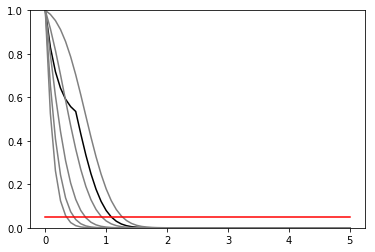

In [6]:
def plot_results(testmus, cls_obs, cls_exp, test_size = 0.05):
    plt.plot(mutests,cls_obs, c = 'k')
    for i,c in zip(range(5),['grey','grey','grey','grey','grey']):
        plt.plot(mutests, cls_exp[i], c = c)
    plt.plot(testmus,[test_size]*len(testmus), c = 'r')
    plt.ylim(0,1)

def invert_interval(testmus, cls_obs, cls_exp, test_size = 0.05):
    point05cross = {'exp':[],'obs':None}
    for cls_exp_sigma in cls_exp:
        yvals = cls_exp_sigma
        point05cross['exp'].append(np.interp(test_size,
                                             list(reversed(yvals)),
                                             list(reversed(testmus))))
        
    yvals = cls_obs
    point05cross['obs'] = np.interp(test_size,
                                    list(reversed(yvals)),
                                    list(reversed(testmus)))
    return point05cross


pyhf.runOnePoint(1.0, data, pdf, init_pars, par_bounds)[-2:]


mutests = np.linspace(0, 5, 61)
tests = [pyhf.runOnePoint(muTest, data, pdf, init_pars, par_bounds)[-2:] for muTest in mutests]
cls_obs = np.array([test[0] for test in tests]).flatten()
cls_exp = [np.array([test[1][i] for test in tests]).flatten() for i in range(5)]

print('\n')
plot_results(mutests, cls_obs, cls_exp)
invert_interval(mutests, cls_obs, cls_exp)